In [1]:
import os
if not os.path.exists('Faceswap-Deepfake-Pytorch'):
    !wget -q https://www.dropbox.com/s/5ji7jl7httso9ny/person_images.zip
    !wget -q https://raw.githubusercontent.com/sizhky/deep-fake-util/main/random_warp.py
    !unzip -q person_images.zip
!pip install -q torch_snippets torch_summary
from torch_snippets import *
from random_warp import get_training_data

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.4/94.4 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.3/204.3 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.0/99.0 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 41.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 45.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 21.9 MB/s eta 0:00

In [3]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [2]:
def crop_face(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    if(len(faces)>0):
        for (x,y,w,h) in faces:
            img2 = img[y:(y+h),x:(x+w),:]
        img2 = cv2.resize(img2,(256,256))
        return img2, True
    else:
        return img, False

In [4]:
!mkdir cropped_faces_personA
!mkdir cropped_faces_personB

def crop_images(folder):
    images = Glob(folder+'/*.jpg')
    for i in range(len(images)):
        img = read(images[i],1)
        img2, face_detected = crop_face(img)
        if(face_detected==False):
            continue
        else:
            cv2.imwrite('cropped_faces_'+folder+'/'+str(i)+'.jpg',cv2.cvtColor(img2, cv2.COLOR_RGB2BGR))
crop_images('personA')
crop_images('personB')

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, items_A, items_B):
        self.items_A = np.concatenate([read(f,1)[None] for f in items_A])/255.
        self.items_B = np.concatenate([read(f,1)[None] for f in items_B])/255.
        self.items_A += self.items_B.mean(axis=(0, 1, 2)) - self.items_A.mean(axis=(0, 1, 2))

    def __len__(self):
        return min(len(self.items_A), len(self.items_B))
    def __getitem__(self, ix):
        a, b = choose(self.items_A), choose(self.items_B)
        return a, b

    def collate_fn(self, batch):
        imsA, imsB = list(zip(*batch))
        imsA, targetA = get_training_data(imsA, len(imsA))
        imsB, targetB = get_training_data(imsB, len(imsB))
        imsA, imsB, targetA, targetB = [torch.Tensor(i).permute(0,3,1,2).to(device) for i in [imsA, imsB, targetA, targetB]]
        return imsA, imsB, targetA, targetB

a = ImageDataset(Glob('cropped_faces_personA'), Glob('cropped_faces_personB'))
x = DataLoader(a, batch_size=32, collate_fn=a.collate_fn)

══════════════════════════════════════════════════════════════════
tensor([[[[0.5224, 0.5701, 0.6167,  ..., 0.5461, 0.5175, 0.4519],
          [0.5308, 0.5769, 0.6223,  ..., 0.5696, 0.5442, 0.4733],
          [0.5424, 0.5883, 0.6375,  ..., 0.5836, 0.5587, 0.4937],
          ...,
          [0.5683, 0.5690, 0.5680,  ..., 0.6283, 0.6263, 0.6185],
          [0.5850, 0.5812, 0.5774,  ..., 0.6506, 0.6458, 0.6390],
          [0.5984, 0.5893, 0.5866,  ..., 0.6638, 0.6561, 0.6562]],

         [[0.3992, 0.4463, 0.4851,  ..., 0.4416, 0.4202, 0.3575],
          [0.4107, 0.4547, 0.4908,  ..., 0.4616, 0.4383, 0.3772],
          [0.4186, 0.4675, 0.5059,  ..., 0.4753, 0.4507, 0.3973],
          ...,
          [0.4348, 0.4257, 0.4211,  ..., 0.5019, 0.5023, 0.4948],
          [0.4426, 0.4406, 0.4313,  ..., 0.5185, 0.5177, 0.5165],
          [0.4551, 0.4486, 0.4409,  ..., 0.5256, 0.5283, 0.5303]],

         [[0.2994, 0.3376, 0.3789,  ..., 0.3303, 0.3064, 0.2423],
          [0.3015, 0.3454, 0.3846,  ..., 

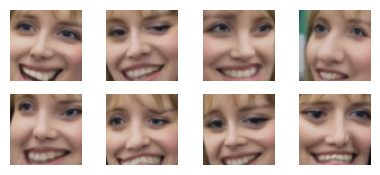

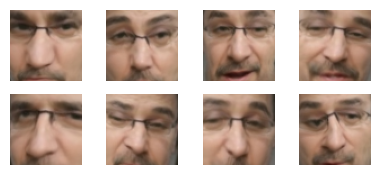

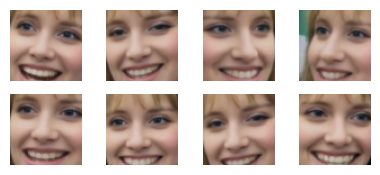

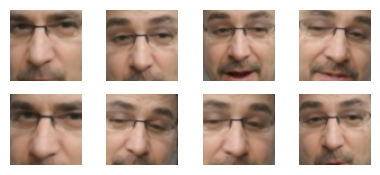

In [ ]:
inspect(*next(iter(x)))

for i in next(iter(x)):
    subplots(i[:8], nc=4, sz=(4,2))

In [ ]:
def _ConvLayer(input_features, output_features):
    return nn.Sequential(
        nn.Conv2d(input_features, output_features, kernel_size=5, stride=2, padding=2),
        nn.LeakyReLU(0.1, inplace=True)
    )

def _UpScale(input_features, output_features):
    return nn.Sequential(
        nn.ConvTranspose2d(input_features, output_features, kernel_size=2, stride=2, padding=0),
        nn.LeakyReLU(0.1, inplace=True)
    )

class Reshape(nn.Module):
    def forward(self, input):
        output = input.view(-1, 1024, 4, 4) # channel * 4 * 4
        return output

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            _ConvLayer(3, 128),
            _ConvLayer(128, 256),
            _ConvLayer(256, 512),
            _ConvLayer(512, 1024),
            nn.Flatten(),
            nn.Linear(1024 * 4 * 4, 1024),
            nn.Linear(1024, 1024 * 4 * 4),
            Reshape(),
            _UpScale(1024, 512),
        )

        self.decoder_A = nn.Sequential(
            _UpScale(512, 256),
            _UpScale(256, 128),
            _UpScale(128, 64),
            nn.Conv2d(64, 3, kernel_size=3, padding=1),
            nn.Sigmoid(),
        )

        self.decoder_B = nn.Sequential(
            _UpScale(512, 256),
            _UpScale(256, 128),
            _UpScale(128, 64),
            nn.Conv2d(64, 3, kernel_size=3, padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x, select='A'):
        if select == 'A':
            out = self.encoder(x)
            out = self.decoder_A(out)
        else:
            out = self.encoder(x)
            out = self.decoder_B(out)
        return out

In [ ]:
def train_batch(model, data, criterion, optimizes):
    optA, optB = optimizers
    optA.zero_grad()
    optB.zero_grad()
    imgA, imgB, targetA, targetB = data
    _imgA, _imgB = model(imgA, 'A'), model(imgB, 'B')

    lossA = criterion(_imgA, targetA)
    lossB = criterion(_imgB, targetB)

    lossA.backward()
    lossB.backward()

    optA.step()
    optB.step()

    return lossA.item(), lossB.item()

In [ ]:
model = Autoencoder().to(device)

dataset = ImageDataset(Glob('cropped_faces_personA'), Glob('cropped_faces_personB'))
dataloader = DataLoader(dataset, 32, collate_fn=dataset.collate_fn)

optimizers = optim.Adam([{'params': model.encoder.parameters()},
                          {'params': model.decoder_A.parameters()}],
                        lr=5e-5, betas=(0.5, 0.999)), \
             optim.Adam([{'params': model.encoder.parameters()},
                          {'params': model.decoder_B.parameters()}],
                        lr=5e-5, betas=(0.5, 0.999))

criterion = nn.L1Loss()

In [ ]:
n_epochs = 5000
log = Report(n_epochs)
!mkdir checkpoint
for ex in range(n_epochs):
    N = len(dataloader)
    for bx,data in enumerate(dataloader):
        lossA, lossB = train_batch(model, data, criterion, optimizers)
        log.record(ex+(1+bx)/N, lossA=lossA, lossB=lossB, end='\r')

    log.report_avgs(ex+1)
    if (ex+1)%100 == 0:
        state = {
                'state': model.state_dict(),
                'epoch': ex
            }
        torch.save(state, './checkpoint/autoencoder.pth')

    if (ex+1)%100 == 0:
        bs = 5
        a,b,A,B = data
        line('A to B')
        _a = model(a[:bs], 'A')
        _b = model(a[:bs], 'B')
        x = torch.cat([A[:bs],_a,_b])
        subplots(x, nc=bs, figsize=(bs*2, 5))

        line('B to A')
        _a = model(b[:bs], 'A')
        _b = model(b[:bs], 'B')
        x = torch.cat([B[:bs],_a,_b])
        subplots(x, nc=bs, figsize=(bs*2, 5))

log.plot_epochs()

mkdir: cannot create directory ‘checkpoint’: File exists
EPOCH: 1.000  lossA: 0.087  lossB: 0.079  (1.47s - 7353.82s remaining)
EPOCH: 2.000  lossA: 0.086  lossB: 0.077  (2.51s - 6270.53s remaining)
EPOCH: 3.000  lossA: 0.090  lossB: 0.080  (3.51s - 5846.40s remaining)
EPOCH: 4.000  lossA: 0.088  lossB: 0.078  (4.55s - 5684.69s remaining)
EPOCH: 5.000  lossA: 0.088  lossB: 0.077  (5.59s - 5587.18s remaining)
EPOCH: 6.000  lossA: 0.087  lossB: 0.077  (6.61s - 5503.46s remaining)
EPOCH: 7.000  lossA: 0.086  lossB: 0.074  (7.65s - 5454.40s remaining)
EPOCH: 8.000  lossA: 0.091  lossB: 0.082  (8.67s - 5411.17s remaining)
EPOCH: 9.000  lossA: 0.087  lossB: 0.082  (9.67s - 5365.21s remaining)
EPOCH: 10.000  lossA: 0.079  lossB: 0.072  (10.68s - 5328.28s remaining)
EPOCH: 11.000  lossA: 0.078  lossB: 0.071  (11.94s - 5413.16s remaining)
EPOCH: 12.000  lossA: 0.079  lossB: 0.069  (13.17s - 5473.48s remaining)
EPOCH: 13.000  lossA: 0.079  lossB: 0.072  (14.35s - 5503.33s remaining)
EPOCH: 14.00

KeyboardInterrupt: 